#### notebook to merge catalogues from the MIGHTEE XMMLSSS early release fields and filter "spurious" sources
last updated: 20 February 2023

In [1]:
import sys, os, time
from matplotlib.pyplot import *
sys.path.append("/idia/projects/mightee/mightee-pol/")
from observations import *
from glob import *
import numpy as np
from astropy.table import Table, QTable
from astropy.coordinates import SkyCoord 

In [2]:
def a_in_b(a,b,distol):
    found = False
    dis = []; dras = []; ddecs = []
    for i in range(len(b['ra'])):   
        dd = 3600.0*(b['dec'][i] - a['dec'])
        dr = 3600.0*(b['ra'][i] - a['ra'])*np.cos(a['dec']*np.pi/180.0)
        dis.append(np.sqrt(dd*dd + dr*dr))
        dras.append(dr)
        ddecs.append(dd)
    dis = np.array(dis)
    n = np.argmin(dis)
    if dis[n] < distol:
        found = True
    return(found,n,dras[n],ddecs[n])

In [3]:
rootdir = '/idia/projects/mightee/mightee-pol/release/XMMLSS/'
fields = ['XMMLSS_12','XMMLSS_13','XMMLSS_14']
field_centres = [SkyCoord(34.4625,-4.83306,unit="deg"),SkyCoord(35.175,-4.83306,unit="deg"),SkyCoord(35.84167,-4.83306,unit="deg")]
dirs = []; infiles = []
for field in fields:
    dirs.append(rootdir+field+'/')
for dir in dirs:
    os.chdir(dir)
    infiles.append(dir+glob('*_detections.fits')[0])
for file in infiles:
    print (file)

/idia/projects/mightee/mightee-pol/release/XMMLSS/XMMLSS_12/XMMLSS_12_1538856059_1539286252_pol_detections.fits
/idia/projects/mightee/mightee-pol/release/XMMLSS/XMMLSS_13/XMMLSS_13_1538942495_1539372679_pol_detections.fits
/idia/projects/mightee/mightee-pol/release/XMMLSS/XMMLSS_14/XMMLSS_14_1539028868_1539460932_pol_detections.fits


In [4]:
tables = []; radii = []; coords = []
for datafile in infiles:
    tables.append(Table.read(datafile))
    
for i in range(len(tables)):
    tables[i].add_column(fields[i],name='pointing')
    print(fields[i],len(tables[i]['ra']))
    coord = SkyCoord(tables[i]['ra'],tables[i]['dec'],unit="deg")
    coords.append(coord)
    radii.append(coord.separation(field_centres[i]).degree)
    
for i in range(len(tables)):
    tables[i].add_column(radii[i],name='distance')
    
#print (coords[0])
#print (radii[0])
#print (tables[0]['distance'])

XMMLSS_12 107
XMMLSS_13 79
XMMLSS_14 145


In [5]:
tout = tables[0]
print (tout.colnames)
print (tout.dtype)
print (len (tout.dtype))
print (tout.dtype[1])
dlist = []
for i in range( len(tout.dtype) ):
    dlist.append(tout.dtype[i])


['ID', 'ra', 'ra_err', 'dec', 'dec_err', 'S_int', 'S_err', 'alpha', 'alpha_err', 'pol', 'pol_b', 'P/I', 'Q/I', 'U/I', 'RM', 'RM_err', 'eff_freq', 'RM_map', '-ve_err_map', '+ve_err_map', 'spec_z', 'phot_z', 'phot_z_uncertainty', 'best_z', 'best_z_uncertainty', 'pointing', 'distance']
[('ID', '>i8'), ('ra', '>f8'), ('ra_err', '>f8'), ('dec', '>f8'), ('dec_err', '>f8'), ('S_int', '>f8'), ('S_err', '>f8'), ('alpha', '>f8'), ('alpha_err', '>f8'), ('pol', '>f8'), ('pol_b', '>f8'), ('P/I', '>f8'), ('Q/I', '>f8'), ('U/I', '>f8'), ('RM', '>f8'), ('RM_err', '>f8'), ('eff_freq', '>f8'), ('RM_map', '>f8'), ('-ve_err_map', '>f8'), ('+ve_err_map', '>f8'), ('spec_z', '>f4'), ('phot_z', '>f8'), ('phot_z_uncertainty', '>f8'), ('best_z', '>f8'), ('best_z_uncertainty', '>f8'), ('pointing', '<U9'), ('distance', '<f8')]
27
>f8


In [6]:
#   merge table[0] with table[1]
tref = tables[0]
tout = Table(names=tref.colnames,dtype=dlist)
print(tout.colnames)
t1 = tables[1]
print ('Length tref: ',len(tref))
print ('Length t1  : ',len(t1))
nmatches = 0
distol = 10.0
delra =[]; 
deldec =[]
#print(tref)

polMatched = []

for j in range(len(tref['ra'])):
    found,n,dra,ddec = a_in_b(tref[j],t1,distol)
    if found:
        nmatches = nmatches + 1
        delra.append(dra)
        deldec.append(ddec)
        if tref['distance'][j] < t1['distance'][n]:
            tout.add_row(tref[j])
        else:
            tout.add_row(t1[n])
    else:
        tout.add_row(tref[j])

print('')
for j in range(len(t1['ra'])):
    found,n,dra,ddec = a_in_b(t1[j],tout,distol)  
    if not found:
        tout.add_row(t1[j])
               
delra = np.array(delra)
deldec =  np.array(deldec)
    
print ("\n Found %d matches" % (nmatches ) )
print (" median position difference: ra,dec = %6.3f %6.3f" % (np.median(delra), np.median(deldec)))

print ('\nMerged file has length: ',len(tout))

['ID', 'ra', 'ra_err', 'dec', 'dec_err', 'S_int', 'S_err', 'alpha', 'alpha_err', 'pol', 'pol_b', 'P/I', 'Q/I', 'U/I', 'RM', 'RM_err', 'eff_freq', 'RM_map', '-ve_err_map', '+ve_err_map', 'spec_z', 'phot_z', 'phot_z_uncertainty', 'best_z', 'best_z_uncertainty', 'pointing', 'distance']
Length tref:  107
Length t1  :  79


 Found 14 matches
 median position difference: ra,dec =  0.090  0.036

Merged file has length:  172


In [7]:
# # make merged catalogue for all fields
tref = tout
tout = Table(names=tref.colnames,dtype=dlist)
t1 = tables[2]
print ('Length tref: ',len(tref))
print ('Length t1  : ',len(t1))
nmatches = 0
distol = 10.0
delra =[]; 
deldec =[]
#print(tref)

polMatched = []

for j in range(len(tref['ra'])):
    found,n,dra,ddec = a_in_b(tref[j],t1,distol)
    if found:
        nmatches = nmatches + 1
        delra.append(dra)
        deldec.append(ddec)
        if tref['distance'][j] < t1['distance'][n]:
            tout.add_row(tref[j])
        else:
            tout.add_row(t1[n])
    else:
        tout.add_row(tref[j])
print('')
for j in range(len(t1['ra'])):
    found,n,dra,ddec = a_in_b(t1[j],tout,distol)  
    if not found:
        tout.add_row(t1[j])
               
delra = np.array(delra)
deldec =  np.array(deldec)
    
print ("\n Found %d matches" % (nmatches ) )
print (" median position difference: ra,dec = %6.3f %6.3f" % (np.median(delra), np.median(deldec)))
print ("Final merged catalogue has length: ", len(tout))
print (tout)
tout.write(rootdir+'russ/xmmlss_polcat.fits',overwrite=True)

Length tref:  172
Length t1  :  145


 Found 10 matches
 median position difference: ra,dec =  0.072  0.000
Final merged catalogue has length:  307
 ID     ra    ra_err ...  best_z_uncertainty  pointing       distance     
---- -------- ------ ... ------------------- --------- -------------------
5131 34.93981   0.03 ...               -99.0 XMMLSS_13 0.24187522143356746
1254 34.94058   0.03 ... 0.26302227737872774 XMMLSS_12 0.48793781315922113
5160 34.93616   0.01 ... 0.04436035970926716 XMMLSS_13 0.23887822572060416
1411 34.90876   0.16 ...               -99.0 XMMLSS_12 0.46079809596514243
1476 34.89442   0.63 ... 0.24528214906689338 XMMLSS_12  0.4359638322571876
5463 34.88638   0.24 ... 0.39288285991420996 XMMLSS_13  0.2915835818208017
5465 34.88757   0.25 ... 0.10617508174141765 XMMLSS_13  0.2924400941723348
5483 34.88489   0.94 ...               -99.0 XMMLSS_13  0.2944453228617745
1559 34.88221   0.34 ...  0.3484589450277021 XMMLSS_12  0.4204008561813256
1892  34.8187   0.01 ... 0.

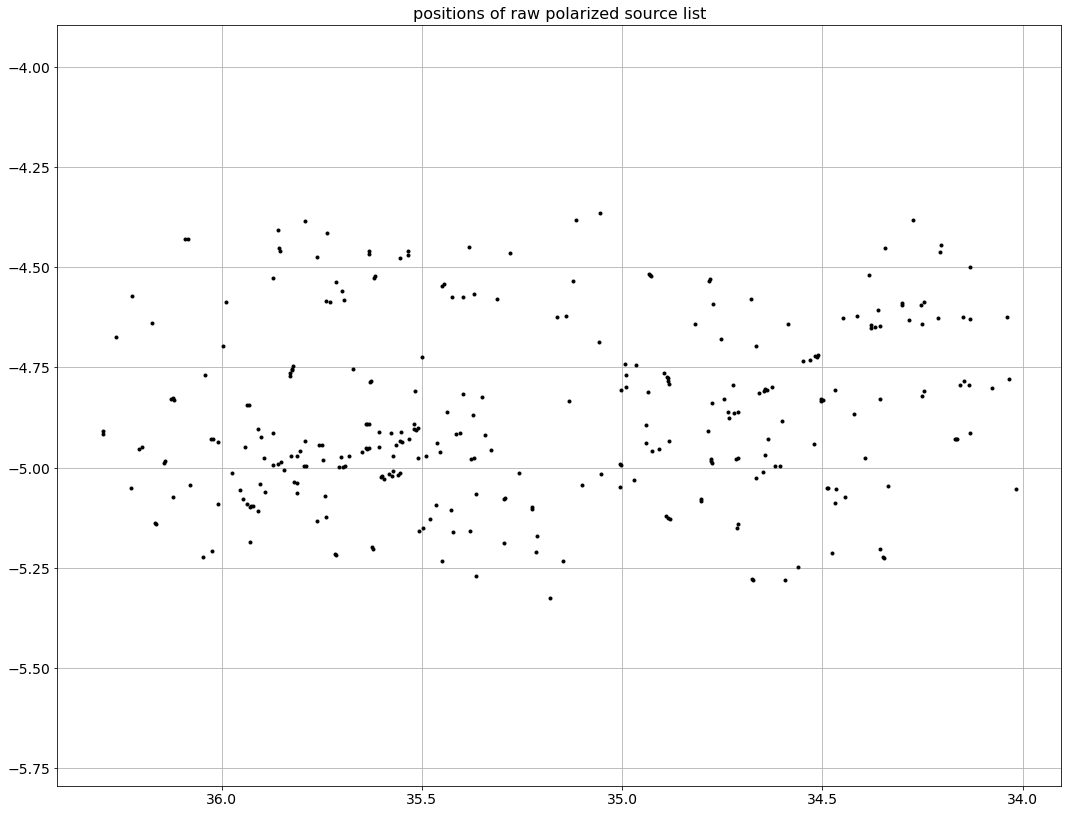

In [8]:
t= tout
fig = figure(figsize=(18,14))
ax = gca()
tick_params(labelsize=14)
ax.invert_xaxis()
axis('equal')
plot(t['ra'],t['dec'],'k.')
title('positions of raw polarized source list',fontsize=16)
grid()
savefig(rootdir+'russ/raw_pol_positions.pdf')
show()

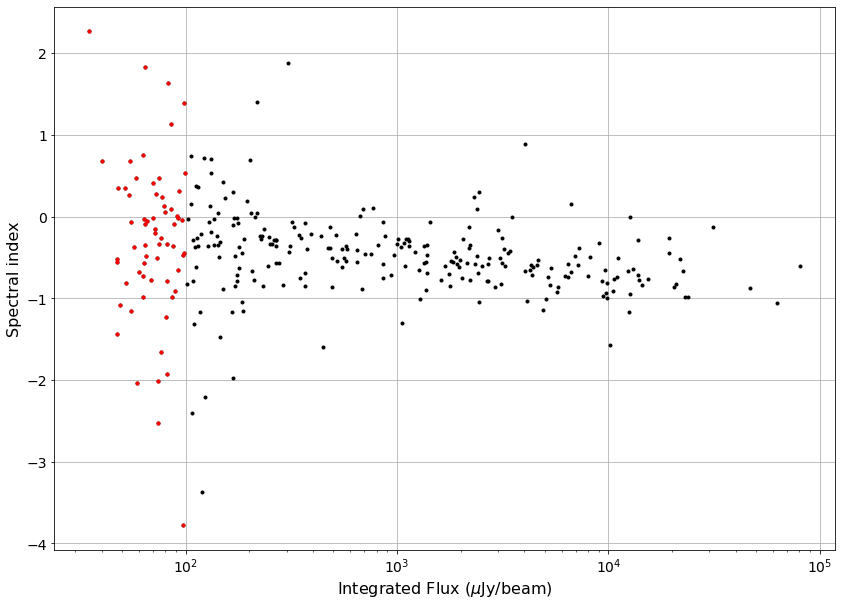

In [9]:
thresh = 100.
fig = figure(figsize=(14,10))
tick_params(labelsize=14)
semilogx(t['S_int'],t['alpha'],'k.')
for i in range(len(t)):
    if t['S_int'][i] < thresh:
        semilogx(t['S_int'][i],t['alpha'][i],'r.')
grid()
xlabel('Integrated Flux ($\mu$Jy/beam)',fontsize=16)
ylabel('Spectral index',fontsize=16)
savefig(rootdir+'russ/alpha_flux.png')
show()

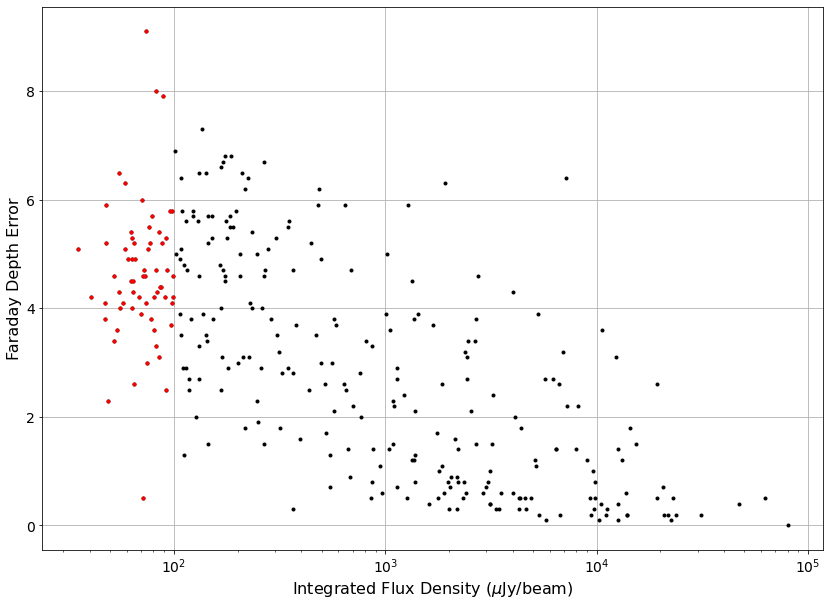

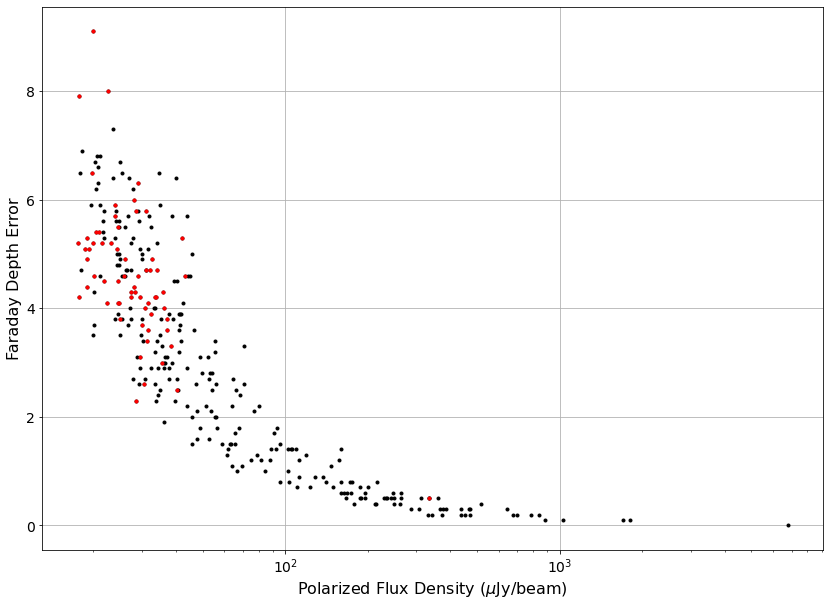

In [10]:
fig = figure(figsize=(14,10))
tick_params(labelsize=14)
semilogx(t['S_int'],t['RM_err'],'k.')
for i in range(len(t)):
    if t['S_int'][i] < thresh:
        semilogx(t['S_int'][i],t['RM_err'][i],'r.')
grid()
xlabel('Integrated Flux Density ($\mu$Jy/beam)',fontsize=16)
ylabel('Faraday Depth Error',fontsize=16)
savefig(rootdir+'russ/fderr_flux.png')
show()

fig = figure(figsize=(14,10))
tick_params(labelsize=14)
semilogx(t['pol'],t['RM_err'],'k.')
for i in range(len(t)):
    if t['S_int'][i] < thresh:
        semilogx(t['pol'][i],t['RM_err'][i],'r.')
grid()
xlabel('Polarized Flux Density ($\mu$Jy/beam)',fontsize=16)
ylabel('Faraday Depth Error',fontsize=16)
savefig(rootdir+'russ/fderr_flux.png')
show()

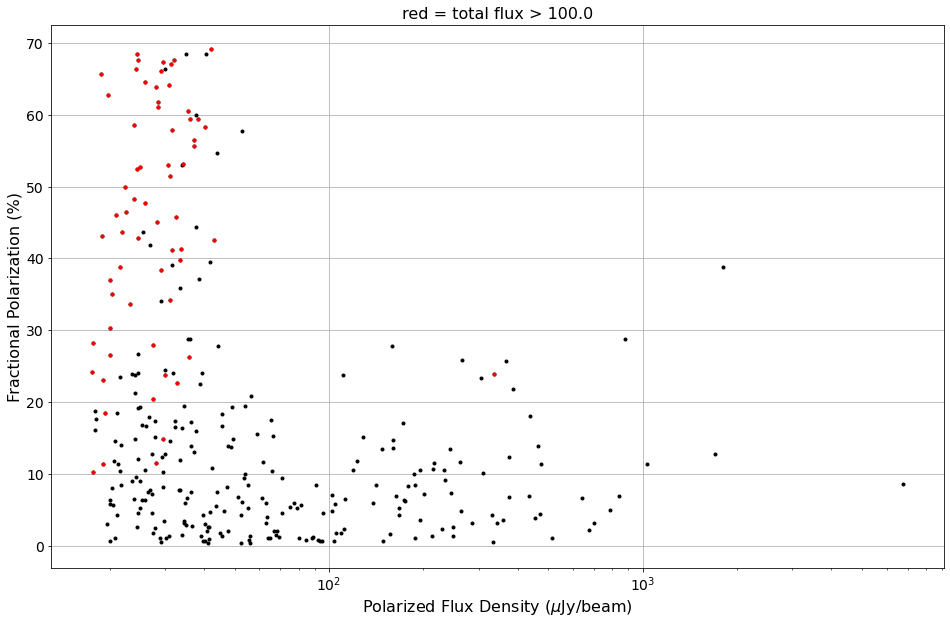

In [11]:
fig = figure(figsize=(16,10))
tick_params(labelsize=14)
semilogx(t['pol'],t['P/I'],'k.')
title('red = total flux > %5.1f' % thresh, fontsize=16)
for i in range(len(t)):
    if t['S_int'][i] < thresh:
        semilogx(t['pol'][i],t['P/I'][i],'r.')
grid()
xlabel('Polarized Flux Density ($\mu$Jy/beam)',fontsize=16)
ylabel('Fractional Polarization (%)',fontsize=16)
savefig(rootdir+'russ/fracp_pflux.pdf')
show()

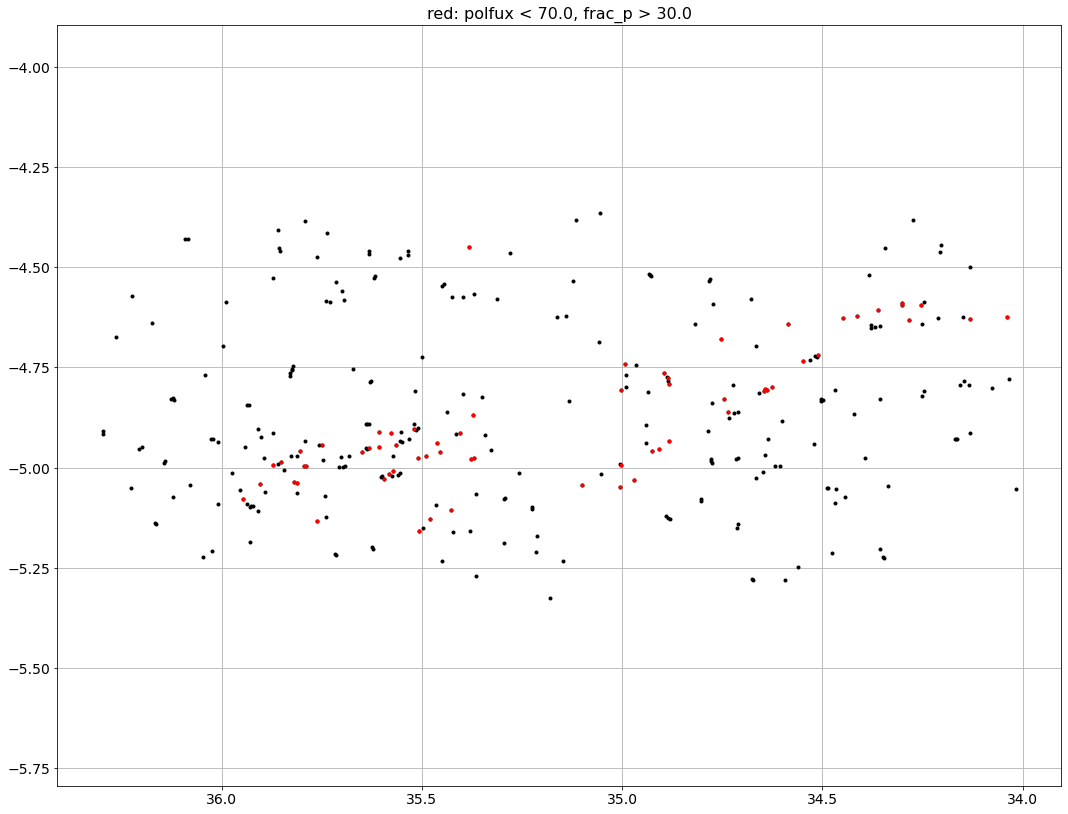

64


In [12]:
count = 0
polflux_limit = 70.0; frac_p_limit = 30.0
fig = figure(figsize=(18,14))
ax = gca()
tick_params(labelsize=14)
ax.invert_xaxis()
axis('equal')
plot(t['ra'],t['dec'],'k.')
title('red: polfux < %4.1f, frac_p > %4.1f' % (polflux_limit, frac_p_limit),fontsize=16)
for i in range(len(t)):
    if t['pol'][i] < polflux_limit and t['P/I'][i] > frac_p_limit:
        count = count + 1
        plot(t['ra'][i],t['dec'][i],'r.')
grid()
savefig(rootdir+'russ/Pfrac_pflux_cut.pdf')
show()
print (count)

In [13]:
print(len(t))
remove = []
for i in range(len(t)):
    if t['pol'][i] < polflux_limit and t['P/I'][i] > frac_p_limit:
        remove.append(i)
print(len(remove))

t.remove_rows(remove)
print('Filtered merged catalogue length: ', len(t))

307
64
Filtered merged catalogue length:  243


In [14]:
outfits = rootdir+'russ/XMMLSS_polcatalogue_filtered.fits'
if os.path.exists(outfits):
    os.remove(outfits)
t.write(outfits, format='fits')

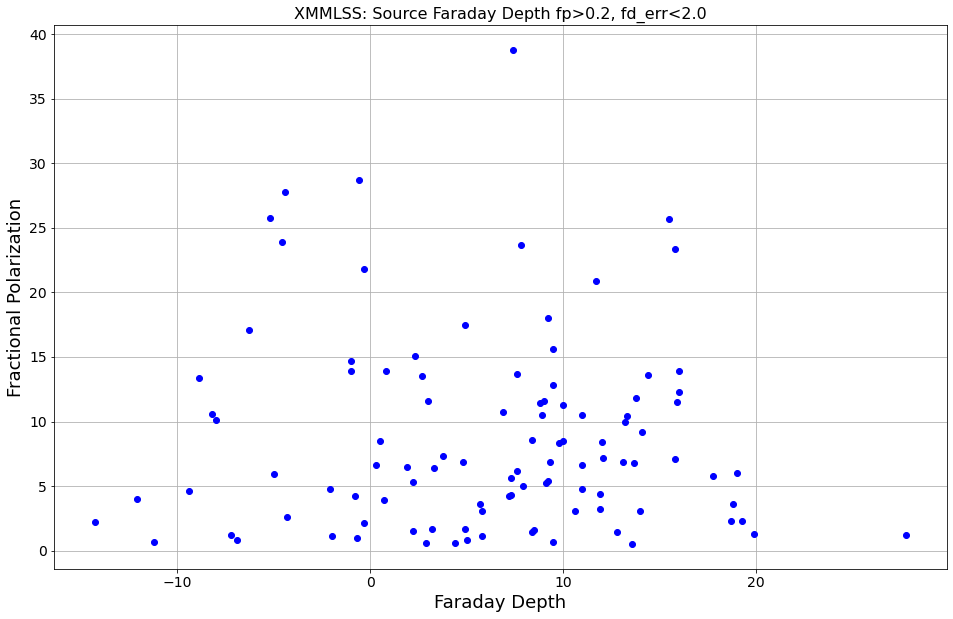

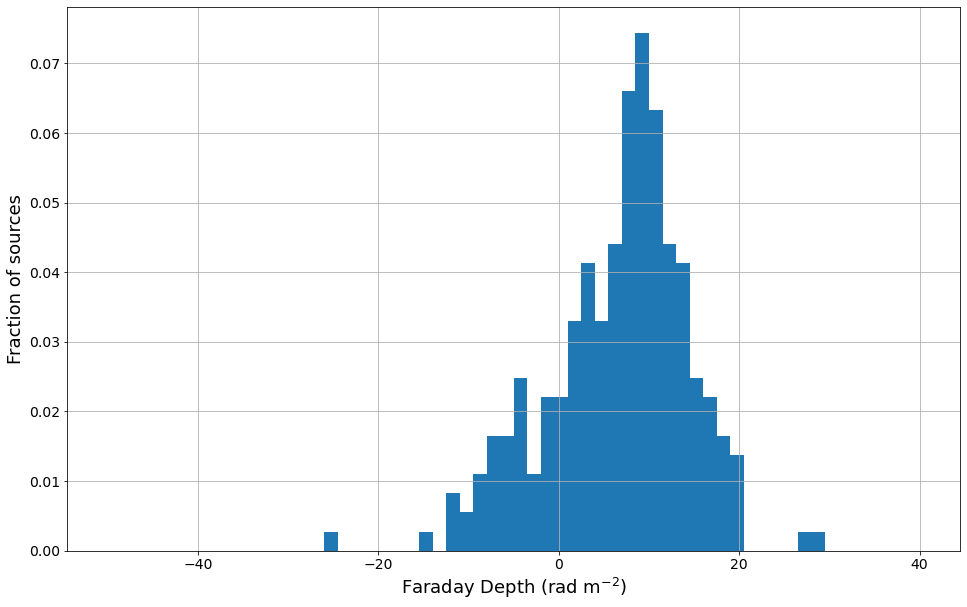

In [15]:
fp_threshold = 0.2
fd_threshold = 100
#thresh=200
fd_err_threshold = 2.0
figure(figsize=(16,10))
ax = gca()
tick_params(labelsize=14)
for i in range(len(t)):
    if t['P/I'][i] > fp_threshold and t['RM_err'][i] < fd_err_threshold:
        plot(t['RM'][i],t['P/I'][i],'bo')
title('XMMLSS: Source Faraday Depth fp>%s, fd_err<%s'%(fp_threshold,fd_err_threshold),fontsize=16)
xlabel('Faraday Depth',fontsize=18)
ylabel('Fractional Polarization',fontsize=18)
grid(True)
savefig(rootdir+"russ/FaradayDepths_fp>%s_fderr<%s"%(fp_threshold,fd_err_threshold)+'.png')
show()

figure(figsize=(16,10))
tick_params(labelsize=14)
hist(t['RM'],bins=60,range=(-50,40),density=True,histtype='stepfilled')
xlabel('Faraday Depth (rad m$^{-2}$)',fontsize=18)
ylabel('Fraction of sources',fontsize=18)
grid()
savefig(rootdir+"russ/FaradayDepthDistribution.png")
show()

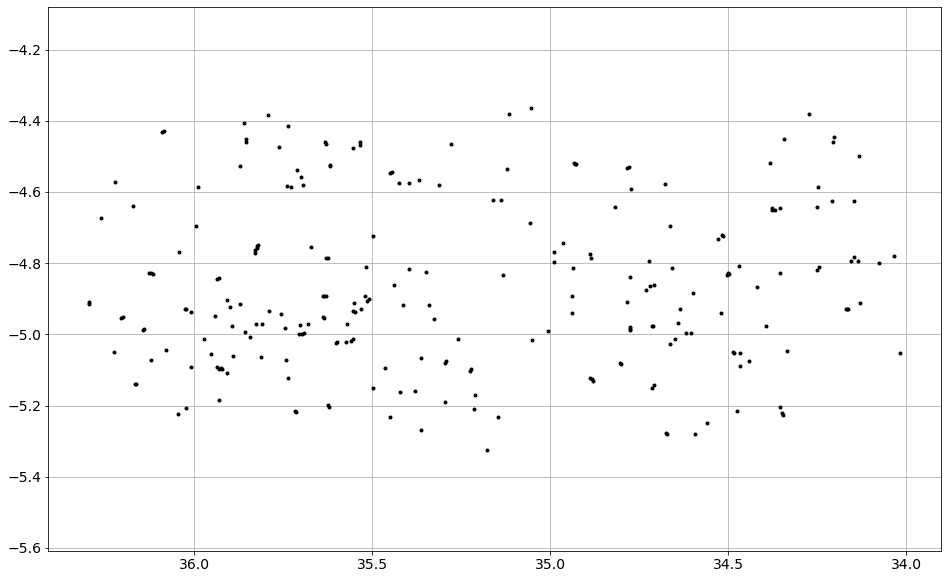

In [16]:
fig = figure(figsize=(16,10))
ax = gca()
tick_params(labelsize=14)
ax.invert_xaxis()
axis('equal')
plot(t['ra'],t['dec'],'k.')
grid()
show()

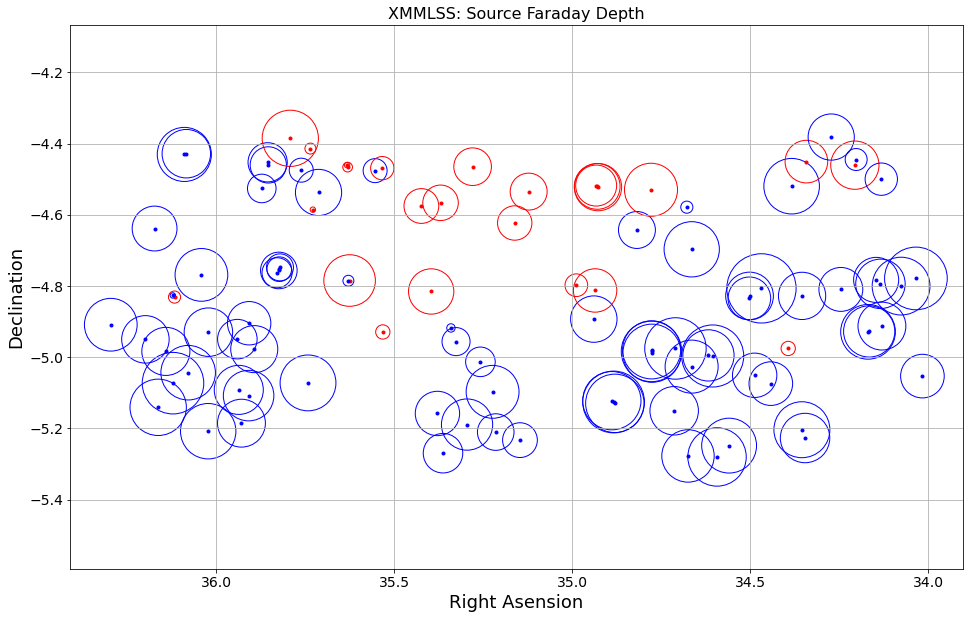

In [17]:
fp_threshold = 0.2
fd_threshold = 100
#thresh=200
fd_err_threshold = 2.0
figure(figsize=(16,10))
ax = gca()
tick_params(labelsize=14)
ax.invert_xaxis()
axis('equal')
for i in range(len(t)):
    if np.fabs(t['RM'][i]) < fd_threshold and t['P/I'][i] > fp_threshold and t['RM_err'][i] < fd_err_threshold:
        size = np.log10(np.fabs(t['RM'][i])+1)/15.0
        if(t['RM'][i]< 0.0):
            plot(t['ra'][i],t['dec'][i],'r.')
            circ = Circle((t['ra'][i],t['dec'][i]),size,color = 'red',fill=False)
        else:
            plot(t['ra'][i],t['dec'][i],'b.')
            circ = Circle((t['ra'][i],t['dec'][i]),size,color = 'blue',fill=False)
        ax.add_artist(circ)
title('XMMLSS: Source Faraday Depth',fontsize=16)
xlabel('Right Asension',fontsize=18)
ylabel('Declination',fontsize=18)
#ylim([-6,-4.0])
grid(True)
savefig(rootdir+"russ/FaradayDepthMap_fp>%s_fderr<%s"%(fp_threshold,fd_err_threshold)+'.png')
show()

crffile=open(rootdir+"russ/faradaydepths_fp>%s_fderr<%s.crf"%(fp_threshold,fd_err_threshold),'w')
crffile.write('#CRTF\n')
crffile.write('global linewidth=2\n')
for i in range(len(t)):
    if np.fabs(t['RM'][i]) < fd_threshold and t['P/I'][i] > fp_threshold and t['RM_err'][i] < fd_err_threshold:
        size = np.log10(np.fabs(t['RM'][i])+1)*100.0
        if(t['RM'][i]< 0.0):
            crfline = "circle[[%9.4fdeg,%9.4fdeg],%7.2farcsec]  color = red\n" % (t['ra'][i],t['dec'][i],size,)        
        else:
            crfline = "circle[[%9.4fdeg,%9.4fdeg],%7.2farcsec]  color = green\n" % (t['ra'][i],t['dec'][i],size)
        crffile.write(crfline)
crffile.close()

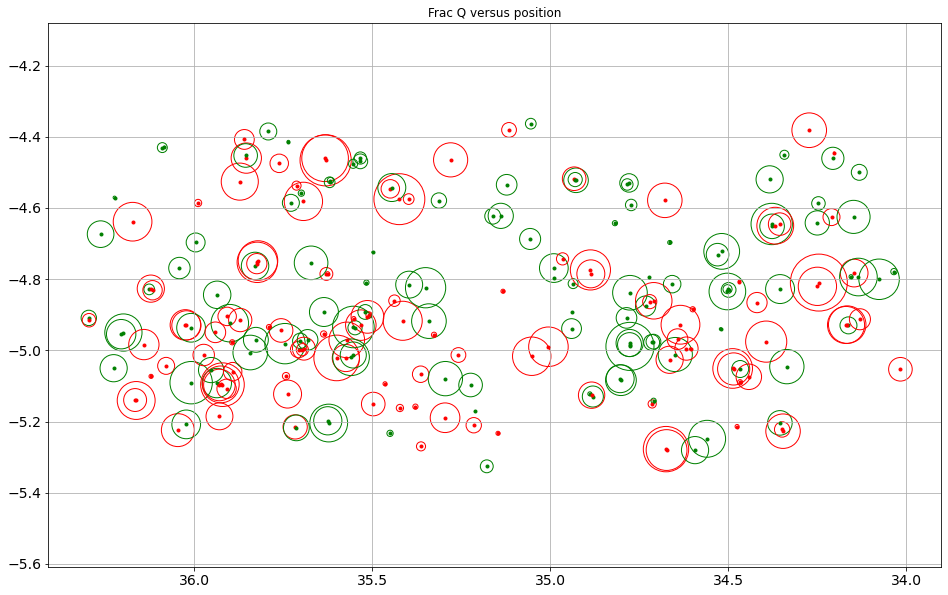

In [18]:
fig = figure(figsize=(16,10))
ax = gca()
tick_params(labelsize=14)
ax.invert_xaxis()
axis('equal')
title('Frac Q versus position')
for i in range(len(t)):
    if t['S_int'][i] > 100:
        size = np.log10(np.fabs(t['Q/I'][i])+1)/20.0
        if t['Q/I'][i] < 0:
            plot(t['ra'][i],t['dec'][i],'r.')
            circ = Circle((t['ra'][i],t['dec'][i]),size,color = 'red',fill=False)
        else:
            plot(t['ra'][i],t['dec'][i],'g.')
            circ = Circle((t['ra'][i],t['dec'][i]),size,color = 'green',fill=False)
        ax.add_artist(circ)
grid()
show()

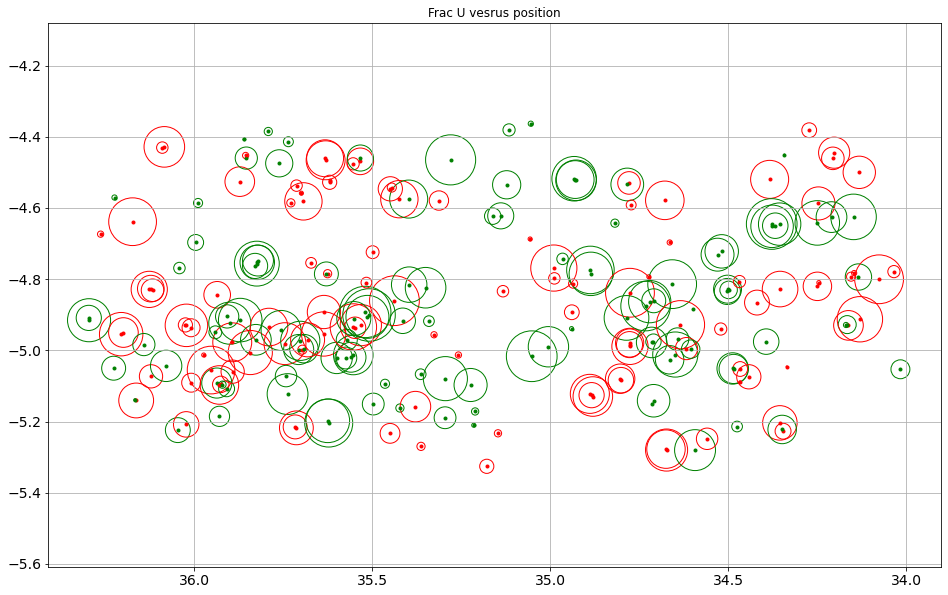

In [19]:
fig = figure(figsize=(16,10))
ax = gca()
tick_params(labelsize=14)
ax.invert_xaxis()
axis('equal')
title('Frac U vesrus position')
for i in range(len(t)):
    if t['S_int'][i] > 100:
        size = np.log10(np.fabs(t['U/I'][i])+1)/20.0
        if t['U/I'][i] < 0:
            plot(t['ra'][i],t['dec'][i],'r.')
            circ = Circle((t['ra'][i],t['dec'][i]),size,color = 'red',fill=False)
        else:
            plot(t['ra'][i],t['dec'][i],'g.')
            circ = Circle((t['ra'][i],t['dec'][i]),size,color = 'green',fill=False)
        ax.add_artist(circ)
grid()
show()